# Time stepping for unsteady finite element problems

This notebook demonstrates some simple time stepping schemes for diffusion and elastic wave propagation problems.

We first import some modules that will be used.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np

We'll also make some animations of the results, for which we need the below code to display videos in the browser:

In [2]:
from tempfile import NamedTemporaryFile
import base64

VIDEO_TAG = """<video controls>
 <source src="data:video/x-webm;base64,{0}" type="video/webm">
 Your browser does not support the video tag.
</video>"""
def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.webm') as f:
            anim.save(f.name, writer='ffmpeg', fps=10, extra_args=['-vcodec', 'libvpx'])
            video = open(f.name, "rb").read()
            
        anim._encoded_video = base64.b64encode(video).decode('ascii')
    
    return VIDEO_TAG.format(anim._encoded_video)

from IPython.display import HTML
def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

## Matrix generators

We consider one-dimensional problems with evenly sized linear elements and consistent mass matrices. For this simple case we can write simple functions to generate the mass and stiffness matrixes: 

In [3]:
def create_matrices(n):
    "Create stiffness and mass matrices of size n x n"

    # Cell length
    h = 1.0/(float(n) - 1.0)
    
    # Create a zero matrix
    M = np.zeros((n, n))
    K = np.zeros((n, n))

    # Add components of small matrix k to K
    k = (1.0/h)*np.array([[1.0, -1.0], [-1.0, 1.0]])
    for i in range(len(K) - 1):
        K[i:i+2, i:i+2] += k

    m = h*np.array([[1.0/3.0, 1.0/6.0], [1.0/6.0, 1.0/3.0]])
    for i in range(len(M) - 1):
        M[i:i+2, i:i+2] += m        
        
    return M, K

## Generalised eigenvalue problem

The critical time step for conditionally stable schemes depends on the largest eigenvalue for the generalised eigenvalue problem

$$
(K - \lambda_{i} M) \psi_{i} = 0
$$

We can explore how the largest eigenvale changes with mesh refinement:

In [4]:
from scipy.linalg import eigvalsh

max_evals = []
for n in [2, 4, 8, 16, 32]:
    M, K = create_matrices(n + 1) 

    # Get largest eigenvalue
    evals = eigvalsh(K, M)
    max_evals.append(np.max(evals))

    h = 1.0/(float(n))
    ratio = "-"
    if len(max_evals) > 1:
        ratio = max_evals[-1]/max_evals[-2]
    print("h, largest eigenvalue, relative increase: {}, {}, {}".format(h, max_evals[-1], ratio))

h, largest eigenvalue, relative increase: 0.5, 48.0, -
h, largest eigenvalue, relative increase: 0.25, 191.99999999999997, 3.9999999999999996
h, largest eigenvalue, relative increase: 0.125, 768.0000000000002, 4.000000000000002
h, largest eigenvalue, relative increase: 0.0625, 3072.0, 3.9999999999999987
h, largest eigenvalue, relative increase: 0.03125, 12288.000000000005, 4.000000000000002


Create matrices and apply boundary conditions

In [5]:
# Problem size
N = 50

# Create matrices
M, K = create_matrices(N) 

# Apply boudary conditions
M[0, :], K[0, :] = 0.0, 0.0
M[:, 0], K[:, 0] = 0.0, 0.0
M[0, 0], K[0, 0] = 1.0, 1.0


In [6]:
# Solve generalised eigenvalue problem
evals = eigvalsh(K, M)

# Get largest eigenvalue
e_max = np.max(evals)
print("Largest eigenvalue: {} ".format(e_max))

Largest eigenvalue: 28789.80669432225 


## Unsteady heat equation

For the unsteadt heat (diffusion) equation, we solve

$$
M \dot{a} + K a  = b
$$

We consider the simple case of $b = 0$.

### Initial condition

We consider an initial condition with a sharp gradient in the centre of the domain:

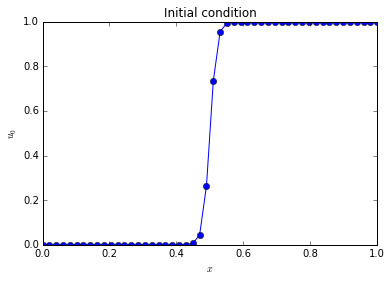

In [7]:
def initial_condition(n):
    x = np.linspace(0.0, 1.0, n)
    return x, 0.5*np.tanh(50.0*(x - 0.5)) + 0.5

x, a_init = initial_condition(50)
plt.xlabel('$x$')
plt.ylabel('$u_{0}$')
plt.title('Initial condition')
plt.plot(x, a_init, '-bo');
    

### Animating solution

Before solving an unsteady problem, we write a function for generating animations of the soliton evolution.

In [8]:
def animate_heat(method, a0, dt, title=None):
    fig = plt.figure()
    ax = plt.axes(xlim=(0, 1), ylim=(0, 1))
    plt.title(title)
    plt.xlabel('$x$')
    plt.ylabel('$u$')
    line, = ax.plot([], [], lw=2)

    def init():
        line.set_data(x, a0)
        return line,

    def animate_method(i, a0):
        if i == 0:
            line.set_data(x, a0)
        else:
            a = method(a0, dt)    
            line.set_data(x, a)
        return line

    return animation.FuncAnimation(fig, animate_method, fargs=(a0,), init_func=init, 
                                   frames=200, interval=100, repeat=False, blit=True)

### Forward Euler

The forward Euler method is conditionally stable, with $\Delta t_{\text{crit}} = 2.0/\lambda_{\max}$. We can compute this for the problem we are considering:

In [9]:
# Critical time step
dt_crit = 2.0/e_max
print("Crtical time step for forward Euler method: {}".format(dt_crit))

Crtical time step for forward Euler method: 6.946903191241044e-05


We now define a function for updating the solution for one time increment: 

In [10]:
def forward_euler(a, dt):
    b_hat = M.dot(a) - dt*K.dot(a)
    b_hat[0] = 0.0
    a[:] = np.linalg.solve(M, b_hat)
    return a

We now solve the heat equation using the forward Euler method an create an animation of the solution. We start with a time step just below the critical time step.

In [11]:
# Set intial condition
x, a0 = initial_condition(N)

# Step time step
dt = 0.99*dt_crit
anim = animate_heat(forward_euler, a0, dt, u'Forward Euler:  $0.99 \Delta t_{crit}$')

# Call animation function to display the animation
display_animation(anim)

We now try a simulation just time step slightly larger than the critical time step.

In [12]:
# Set intial condition
x, a0 = initial_condition(N)

# Step time step
dt = 1.02*dt_crit
anim = animate_heat(forward_euler, a0, dt, 'Forward Euler: $1.02 \Delta t_{crit}$')

# Call animation function to display the animation
display_animation(anim)

### Backward Euler

We now switch to the backward Euler method.

In [13]:
def backward_euler(a, dt):
    b_hat = M.dot(a)
    b_hat[0] = 0.0
    a[:] = np.linalg.solve(M + dt*K, b_hat)
    return a

We now solve the problem using the backward Euler method with a time step that is 10 times greater than the critical time step for the forward Euler case:

In [14]:
# Set intial condition
x, a0 = initial_condition(N)

# Step time step
dt = 20.0*dt_crit
anim = animate_heat(backward_euler, a0, dt, 'Backward Euler: $20 \Delta t_{crit}$')

# Call animation function to display the animation
display_animation(anim)

### Crank-Nicolson

We now use the Crank-Nicolson method. Recall that it is second-order acurate and unconditionally/neutrally stable.

In [15]:
def crank_nicolson(a, dt):
    b_hat = M.dot(a) + 0.5*dt*M.dot(a_dot)
    b_hat[0] = 0.0
    a1 = np.linalg.solve(M + 0.5*dt*K, b_hat)

    a_dot1 = (2.0/dt)*(a1 - a) - a_dot 
    a[:] = a1[:]
    a_dot[:] = a_dot1[:]
    return a

In [16]:
# Set intial condition
x, a0 = initial_condition(N)
a_dot = np.zeros(len(a0))

# Step time step
dt = 20.0*dt_crit
anim = animate_heat(crank_nicolson, a0, dt, 'Crank-Nicolson: $20 \Delta t_{crit}$')

# Call animation function to display the animation
display_animation(anim)

### Comparing the backward Euler and Crank-Nicolson methods

In [17]:
x, a0_be = initial_condition(N)
x, a0_cn = initial_condition(N)
a_dot = np.zeros(len(a0))

# Create a simple animation
fig = plt.figure()
ax = plt.axes(xlim=(0, 1), ylim=(0, 1))

# Initialise lines
lines = []
for index in range(2):
    lobj = ax.plot([],[])[0]
    lines.append(lobj)

def compare_animate(i, a_be, a_cn, dt):
    if i > 0:
        a_be = backward_euler(a0_be, dt)
        a_cn = crank_nicolson(a0_cn, dt)
    
    lines[0].set_data(x, a_be)
    lines[1].set_data(x, a_cn)
    return lines
        
dt = 200.0*dt_crit
anim = animation.FuncAnimation(fig, compare_animate, fargs=(a0_be, a0_cn, dt),
                            frames=20, interval=200, repeat=False, blit=True)

# Call animation function to display the animation
display_animation(anim)

## Elastodynamics

We now look at the central differen scheme for elastic wave propagation in a bar.

### Critical time step

First, we compute the critical time step:

In [18]:
dt_crit = 2.0/np.sqrt(e_max)
print("Critical time step for central difference method: {}".format(dt_crit))

Critical time step for central difference method: 0.011787199150978186


### Loading function

We load to bar by applying a 'triangular' loading function at the right-hand end. We spread the 'triangle' over a time interaval of $20\Delta t_{\text{crit}}$.

In [19]:
def load_function(t):
    num_dt_ramp = 20
    if t < num_dt_ramp*dt_crit:
        b = t
    elif t < 2*num_dt_ramp*dt_crit:   
        b = (num_dt_ramp*dt_crit) - (t - num_dt_ramp*dt_crit)
    else:
        b = 0.0
    return b

### Central difference scheme

The below function computes the solution updates for one step of a central difference scheme.

In [20]:
def central_difference(a1, a0, t, dt):
    b_hat = M.dot(2.0*a1 - a0) - dt*dt*K.dot(a1) 

    # Get load (right-hand end) and apply Dirichlet bc (left-hand end)
    b_hat[-1] = load_function(t)
    b_hat[0] = 0.0
    
    # Solve and update
    a = np.linalg.solve(M, b_hat)
    a0[:] = a1[:]
    a1[:] = a[:]
    return a

We now write a function to animate the solution (this is why it looks more complicated than a straightforward time stepping loop):

In [21]:
def animate_wave(a1, a0, t, dt, num_steps=400, title=None):
    fig = plt.figure()
    ax = plt.axes(xlim=(0, 1), ylim=(-30.0, 30.0))
    plt.title(title)
    plt.xlabel('$x$')
    plt.ylabel('$u$')
    line, = ax.plot([], [], lw=2)

    def init():
        line.set_data(x, a1)
        return line,

    def animate_method(i, a1, a0, t, dt):
        if i == 0:
            line.set_data(x, a1)
        else:
            a = central_difference(a1, a0, i*dt, dt)    
            line.set_data(x, a)
        return line

    return animation.FuncAnimation(fig, animate_method, fargs=(a1, a0, t, dt), init_func=init, 
                                   frames=num_steps, interval=100, repeat=False, blit=True)

We now run the central difference solver with a time step just below the critical time step.

In [22]:
x, a1 = initial_condition(N)
a1 = np.zeros(len(a1))
a0 = np.zeros(len(a1))

anim = animate_wave(a1, a0, 0.0, 0.95*dt_crit, num_steps=400, 
                    title="central difference scheme: $0.95 \Delta t_{crit}$")
display_animation(anim)

The solution remains stable, but errors develop. In particular, high frequence errors are evident, and the absence of energy dissipation these modes persist.

Next, we run the central difference solver with a time step just over the critical time step, with a time step of $1.01\Delta t_{crit}$:

In [23]:
x, a1 = initial_condition(N)
a1 = np.zeros(len(a1))
a0 = np.zeros(len(a1))

anim = animate_wave(a1, a0, 0.0, 1.01*dt_crit, num_steps=400, 
                    title="central difference scheme: $1.01 \Delta t_{crit}$")
display_animation(anim)

The wave propagation problem becomes unstable very quickly. There are no dissipative effects to slow the growth of the oscillations.